# Part 2 - SCA: Timing Attack


### 1. Explaining the code operation
From looking at the source code:
> ```C
> #include <stdio.h>
> #include <string.h>
> #include <unistd.h>
> 
> #define SECRET_PASSWORD "???"
> 
> int verifyPassword(const char *inPassword) {
>     if (strlen(inPassword) != strlen(SECRET_PASSWORD)) {
>         return 0;
>     }
> 
>     usleep(1000);
> 
>     for (int i = 0; i < strlen(SECRET_PASSWORD); i++) {
>         if (inPassword[i] != SECRET_PASSWORD[i]) {
>             return 0;
>         }
>         usleep(10000);
>     }
> 
>     return 1;
> }
> 
> int main(int argc, char *argv[]) {
>     if (argc != 2) {
>         return 1;
>     }
>     
>     if (verifyPassword(argv[1])) {
>         return 0;
>     }
>     return 1;
> }
> ```

 we learn a few things:
 1. The code expects the password as the 2nd CLI argumentm, after the executable. It will return instantly if won't receive exactly 1 argument after the executable.
 2. Our indication to success is in the return code of the program (0 - success, 1 - failure).
 3. The first check is that the length of the entered password matches. The program will quit if match would not be achieved.
 4. After the length check, the program sleeps for $1000$ us.
 5. Then it continues to compare the password char by char. If a compare fails, the program quits, else it waits $10000$ us and than checks the next char.

 The function includes `usleep(10000)`, this probably to make our job easier when deploying the Timing Attack, its accuracy can be affected from other running processes, the linux manual page describes this function with the following description:

        The usleep() function suspends execution of the calling thread for
       (at least) usec microseconds.  The sleep may be lengthened
       slightly by any system activity or by the time spent processing
       the call or by the granularity of system timers.

So it means we need to refer to the value inside `usleep` as a lower bound for our measurements.

Another explanation for adding the `usleep` is that if the `usleep` are inserted correctly (not the case here), they cause the timing variance that the actual calculations take be least significant in comparison to this delay (causing the leakage through the timings to have much smaller SNR).


### 2. Finding the password
We now established that if the password length is incorrect, the program returns instantly (without sleeps). 
And that between the password length check and the next check, we have a delay of $1000$ us.

So, say we wish to check if the length is $l$. We can run the program with an arbitrary string with a length $l$ and measure the execution time.

If the result is longer then $1000$ us, we'll assume we have found the correct length.
We'll plot a graph showing the execution time versus the password length.

Let us first declare a python function which runs a shell command, and outputs its execution time and its return code.

In [16]:
import time
import subprocess


def run_command_and_measure_time(cmd: list[str]) -> tuple[int, float]:
    # Measure start time
    start_time = time.perf_counter()

    # Run the command
    result = subprocess.run(cmd)

    # Measure end time
    end_time = time.perf_counter()

    exec_time = end_time - start_time

    return result.returncode, exec_time


EXECUTABLE_PATH = './password_checker'

def run_exercise_executable_with_password(password: str) -> tuple[int, float]:
    return run_command_and_measure_time([EXECUTABLE_PATH, password])


Let us now run the command for every possible password length (max is $100$ as received from intelligence), and an arbitrary choice of password (0s).

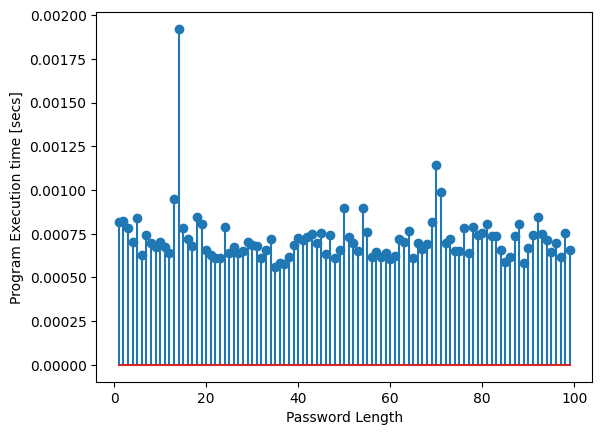

Password length is 14


In [17]:
from matplotlib import pyplot as plt

MAX_PASSWORD_LEN = 100

lens = range(1, MAX_PASSWORD_LEN, 1)
time_vector = []

for i in lens:
    password = '0' * i
    _, exec_time = run_exercise_executable_with_password(password)
    time_vector.append(exec_time)

# plot timing
plt.stem(lens, time_vector)
plt.xlabel('Password Length')
plt.ylabel('Program Execution time [secs]')
plt.show()

# Get the length with the largest exec time
pass_len = lens[time_vector.index(max(time_vector))]
print(f"Password length is {pass_len}")


We indeed see a high peek around the length of $14$, which looks like it is longer than the mean of the others in more than $1000$ us.
So the password length based on our timing attack is probably $14$

### 3. Recover the Password
Now we can do pretty much the same things, except, we'll iterate over each character a string with a length of the password.

We'll start from a blank string, and 

In [18]:

import string

def get_string_padded(orig: str, pad_len: int) -> str:
    """Pads string to pad_len length"""
    return orig + '0' * (pad_len - len(orig))


password = ''


for i in range(pass_len):
    time_vector = []
    
    for char in string.printable:
        temp_password = password + char
        # Measure time with current char - padded to password len
        _, exec_time = run_exercise_executable_with_password(get_string_padded(temp_password, pass_len))
        time_vector.append(exec_time)
    
    print(temp_password, end='\r')
    # Char with the max execution time      
    correct_char = string.printable[time_vector.index(max(time_vector))]
    password += correct_char


print(f'Password is {password}')


Password is IL0v3H0m3w0rk!


### 4. Password Validation
So, our method worked, and we found the password. The password is `IL0v3H0m3w0rk!`.

Let us validate it (from the program return code).

In [19]:
assert run_exercise_executable_with_password(password)[0] == 0, f"{password} is not the correct password."
print(f"{password} is the correct password.")

IL0v3H0m3w0rk! is the correct password.


And it is indeed the correct password.

### 5. Preventing such attacks

Let us suggest the following methods:

1. Balancing the comparison algorithm - try to write the code in such way, that for each check, both paths will have the same time. For example:
```C
int verifyPassword(const char *inPassword) {
    int success = 1;
    if (strlen(inPassword) != strlen(SECRET_PASSWORD)) {
        success = 0;
    }

    usleep(1000);

    for (int i = 0; i < strlen(SECRET_PASSWORD); i++) {
        if (inPassword[i] != SECRET_PASSWORD[i]) {
            success = 0;
        }
        usleep(10000);
    }

    return success;
}
```
such algorithm would take longer time to reject the password, but it would take a constant amount of time for each calculation, so timing attack would not be possible.

2. Try to insert a large random delay instead of a constant one. 
Pros - as we stated, adding a large delay, could decrease the SNR of the timing leakage, and makes the attack harder. Also randomizing it, would not let an attacker just subtract the delay we've put, will also harden the attack.
Cons - would take more time for a password check.

3. Use an hash comparison and not compare the password. To balance the delay of the calculation, we'll always add padding to some constant length of the password (maximum value). 
Pros - prevents timing attacks. Also, the password is not reversible from the compiled file (currently running `strings password_checker` reveals the password), so even if an attacker got hold on our executable file, it can not reproduce the password, only the hash of it is stored, and we're assuming that hash functions are irreversible. 
Cons - more complex implementation (probably larger binary) and slow performance.  
